In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from enum import IntEnum

MAX_ROWS = 250
MAX_COLS = 100

pd.set_option('display.max_rows', MAX_ROWS)
pd.set_option('display.max_columns', MAX_COLS)

# prefix = "AMZN_2012-06-21_34200000_57600000"
prefix = "INTC_2012-06-21_34200000_57600000"

trades_data_file = f"./data/{prefix}_message_5.csv"
orderbook_data_file = f"./data/{prefix}_orderbook_5.csv"

trade_df = pd.read_csv(trades_data_file, names=(
    'time',
    'type',
    'orderId',
    'size',
    'price',
    'direction',
),
    skiprows=1
)

orderbook_df = pd.read_csv(orderbook_data_file, names=(
    'ask1_price',
    'ask1_size',
    'bid1_price',
    'bid1_size',

    'ask2_price',
    'ask2_size',
    'bid2_price',
    'bid2_size',

    'ask3_price',
    'ask3_size',
    'bid3_price',
    'bid3_size',

    'ask4_price',
    'ask4_size',
    'bid4_price',
    'bid4_size',

    'ask5_price',
    'ask5_size',
    'bid5_price',
    'bid5_size',
))

df = pd.concat([trade_df, orderbook_df], axis=1)
df['event_lapse'] = df['time'].diff().fillna(0)

class OrderbookEventTypes(IntEnum):
    Limit=1
    PartialCancel=2
    Deletion=3
    ExecutionOfVisibleOrder=4
    ExecutionOfHiddenOrder=5
    TradingHalt=7

class OrderbookIndexes(IntEnum):
    Bid=0
    Ask=1

class OrderbookTypes(IntEnum):
    Limit=0
    Market=1
    Cancel=2

# Remove hidden orderbook events
df = df[
    # (df['type'] != OrderbookEventTypes.ExecutionOfHiddenOrder) & 
    (df['type'] != OrderbookEventTypes.TradingHalt) &
    (df['time'])
    ]

DEPTH = 3
ORDER_TYPES = 3
PRICE_TICK = 100
HALF_PRICE_TICK = PRICE_TICK / 2
NORMALIZED_QUEUE_MAX = 100

# 2.2.2 Estimation of the reference price

In [56]:
df['midprice'] = (df['bid1_price'] + df["ask1_price"]) / 2
spread = df["ask1_price"] - df['bid1_price']

spread_conditions = [
    df['midprice'] % PRICE_TICK != 0,
    df["ask1_size"] >= df['bid1_size'],
    df["ask1_size"] < df['bid1_size'],
]

midpoint_leans = [
    df['midprice'],
    df['midprice'] + HALF_PRICE_TICK,
    df['midprice'] - HALF_PRICE_TICK,
]

df['reference_price'] = np.select(spread_conditions, midpoint_leans)

## Normalize data around reference price

In [57]:
for depth_level in range(0, DEPTH):
    price_depth = HALF_PRICE_TICK + (PRICE_TICK * depth_level)

    bid_price_level = df['reference_price'] - price_depth
    ask_price_level = df['reference_price'] + price_depth

    bid_conditions = [
        bid_price_level == df['bid1_price'],
        bid_price_level == df['bid2_price'],
        bid_price_level == df['bid3_price'],
        bid_price_level == df['bid4_price'],
        bid_price_level == df['bid5_price'],
    ]
    ask_conditions = [
        ask_price_level == df['ask1_price'],
        ask_price_level == df['ask2_price'],
        ask_price_level == df['ask3_price'],
        ask_price_level == df['ask4_price'],
        ask_price_level == df['ask5_price'],
    ]

    bid_choices = [
        df['bid1_size'],
        df['bid2_size'],
        df['bid3_size'],
        df['bid4_size'],
        df['bid5_size']
    ]
    ask_choices = [
        df['ask1_size'],
        df['ask2_size'],
        df['ask3_size'],
        df['ask4_size'],
        df['ask5_size']
    ]

    df[f'norm_bid{depth_level + 1}_price'] = bid_price_level
    df[f'norm_bid{depth_level + 1}_size'] = np.select(bid_conditions, bid_choices)
    
    df[f'norm_ask{depth_level + 1}_price'] = ask_price_level
    df[f'norm_ask{depth_level + 1}_size'] = np.select(ask_conditions, ask_choices)

df.drop(columns=[
    'ask1_price',
    'ask1_size',
    'bid1_price',
    'bid1_size',

    'ask2_price',
    'ask2_size',
    'bid2_price',
    'bid2_size',

    'ask3_price',
    'ask3_size',
    'bid3_price',
    'bid3_size',

    'ask4_price',
    'ask4_size',
    'bid4_price',
    'bid4_size',

    'ask5_price',
    'ask5_size',
    'bid5_price',
    'bid5_size',
], inplace=True)
display(df)

,time,type,orderId,size,price,direction,event_lapse,midprice,reference_price,norm_bid1_price,norm_bid1_size,norm_ask1_price,norm_ask1_size,norm_bid2_price,norm_bid2_size,norm_ask2_price,norm_ask2_size,norm_bid3_price,norm_bid3_size,norm_ask3_price,norm_ask3_size
0,34200.006241,1.0,16114545.0,100.0,275200.0,-1.0,0.000000,275150.0,275150.0,275100.0,400,275200.0,66,275000.0,100,275300.0,1000,274900.0,200,275400.0,373
1,34200.006462,1.0,16114695.0,100.0,275500.0,-1.0,0.000221,275150.0,275150.0,275100.0,400,275200.0,166,275000.0,100,275300.0,1000,274900.0,200,275400.0,373
2,34200.048864,3.0,16063194.0,100.0,275000.0,1.0,0.042402,275150.0,275150.0,275100.0,400,275200.0,166,275000.0,100,275300.0,1000,274900.0,200,275400.0,373
3,34200.048883,3.0,15833239.0,100.0,275100.0,1.0,0.000020,275150.0,275150.0,275100.0,400,275200.0,166,275000.0,0,275300.0,1000,274900.0,200,275400.0,373
4,34200.048989,1.0,16127246.0,100.0,275000.0,1.0,0.000106,275150.0,275150.0,275100.0,300,275200.0,166,275000.0,0,275300.0,1000,274900.0,200,275400.0,373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581024,57599.860444,3.0,287139444.0,34600.0,267200.0,-1.0,0.011408,267150.0,267150.0,267100.0,7191,267200.0,122704,267000.0,31183,267300.0,171683,266900.0,28495,267400.0,109774
581025,57599.860635,1.0,287166269.0,16600.0,267000.0,1.0,0.000191,267150.0,267150.0,267100.0,7191,267200.0,88104,267000.0,31183,267300.0,171683,266900.0,28495,267400.0,109774
581026,57599.870108,3.0,287016725.0,600.0,267400.0,-1.0,0.009473,267150.0,267150.0,267100.0,7191,267200.0,88104,267000.0,47783,267300.0,171683,266900.0,28495,267400.0,109774
581027,57599.939645,1.0,287173095.0,100.0,267200.0,-1.0,0.069536,267150.0,267150.0,267100.0,7191,267200.0,88104,267000.0,47783,267300.0,171683,266900.0,28495,267400.0,109174


### 2.3 Model I: Collection of independent queues
Figure 1: Limit order book

In [58]:
def getOrdersFromData(dataframe, depth, isBid):
    correctDirection = 1 if isBid else -1
    limitOrder = (dataframe['type'] == 1)
    cancelOrder = (dataframe['type'] == 2) | (dataframe['type'] == 3)
    marketOrderCondititons = (
        (dataframe['type'] == 4) &
        (dataframe[f'norm_bid{depth}_size'] > 0) &
        (dataframe['direction'] == correctDirection)
    )

    return (dataframe[limitOrder], dataframe[cancelOrder], dataframe[marketOrderCondititons])

In [59]:
def generateIntensityValues(dataframe):
    lambdas = np.zeros((DEPTH, 2, ORDER_TYPES, NORMALIZED_QUEUE_MAX))

    is_event_in_bid = [
        (dataframe['norm_bid1_price'] == dataframe['price']),
        (dataframe['norm_bid2_price'] == dataframe['price']),
        (dataframe['norm_bid3_price'] == dataframe['price']),
    ]
    is_event_in_ask = [
        (dataframe['norm_ask1_price'] == dataframe['price']),
        (dataframe['norm_ask2_price'] == dataframe['price']),
        (dataframe['norm_ask3_price'] == dataframe['price']),
    ]

    pd.options.mode.chained_assignment = None  # default='warn'

    for price_level in range(0, DEPTH):
        orders_at_depth = dataframe.loc[(is_event_in_bid[price_level]) | (is_event_in_ask[price_level])]
        orders_at_depth['dt_order'] = orders_at_depth['time'].diff().fillna(0)
        
        bids_at_depth = orders_at_depth.loc[is_event_in_bid[price_level]]
        asks_at_depth = orders_at_depth.loc[is_event_in_ask[price_level]]

        average_event_size = (bids_at_depth['size'].mean() + asks_at_depth['size'].mean()) / 2

        bids_at_depth.loc[:, 'queue_length'] = np.ceil(bids_at_depth[f'norm_bid{price_level + 1}_size'].astype(float) / average_event_size)
        asks_at_depth.loc[:, 'queue_length'] = np.ceil(asks_at_depth[f'norm_ask{price_level + 1}_size'].astype(float) / average_event_size)

        print(f'Price Level {price_level + 1} | AES {average_event_size}')

        for queue_index in range(0, NORMALIZED_QUEUE_MAX):
            bid_queue = bids_at_depth.loc[bids_at_depth['queue_length'] == queue_index]
            ask_queue = asks_at_depth.loc[asks_at_depth['queue_length'] == queue_index]

            bidLimitOrder, bidCancelOrder, bidMarketOrderCondititons  = getOrdersFromData(bid_queue, price_level + 1, True)
            askLimitOrder, askCancelOrder, askMarketOrderCondititons = getOrdersFromData(ask_queue, price_level + 1, False)
            
            numberOfOrdersAtBidQueue = len(bid_queue)
            numberOfOrdersAtAskQueue = len(ask_queue)

            dt_order = orders_at_depth['dt_order'].mean()

            bid_denominator = numberOfOrdersAtBidQueue * dt_order
            if(bid_denominator == 0 or np.isnan(bid_denominator)):
                bid_denominator = 0.0000001
            
            ask_denominator = numberOfOrdersAtAskQueue * dt_order
            if(ask_denominator == 0 or np.isnan(ask_denominator)):
                ask_denominator = 0.0000001

            bidLimitIntensity = (len(bidLimitOrder)) / (bid_denominator)
            bidCancelIntensity = (len(bidCancelOrder)) / (bid_denominator)
            bidMarketIntensity = (len(bidMarketOrderCondititons)) / (bid_denominator)
            
            askLimitIntensity = (len(askLimitOrder)) / (ask_denominator)
            askCancelIntensity = (len(askMarketOrderCondititons)) / (ask_denominator)
            askMarketIntensity = (len(askMarketOrderCondititons)) / (ask_denominator)

            lambdas[price_level, OrderbookIndexes.Bid, OrderbookTypes.Limit, queue_index] = bidLimitIntensity
            lambdas[price_level, OrderbookIndexes.Bid, OrderbookTypes.Market, queue_index] = bidMarketIntensity
            lambdas[price_level, OrderbookIndexes.Bid, OrderbookTypes.Cancel, queue_index] = bidCancelIntensity

            lambdas[price_level, OrderbookIndexes.Ask, OrderbookTypes.Limit, queue_index] = askLimitIntensity
            lambdas[price_level, OrderbookIndexes.Ask, OrderbookTypes.Market, queue_index] = askMarketIntensity
            lambdas[price_level, OrderbookIndexes.Ask, OrderbookTypes.Cancel, queue_index] = askCancelIntensity
    # if any values are nan, set them to 0
    lambdas = np.nan_to_num(lambdas)
    return lambdas
lambdas = generateIntensityValues(df)

Price Level 1 | AES 480.2373359306095
Price Level 2 | AES 457.65417935801315
Price Level 3 | AES 452.9584317825644


### Figure 2: Intensities at Q+- i= 1, 2, 3

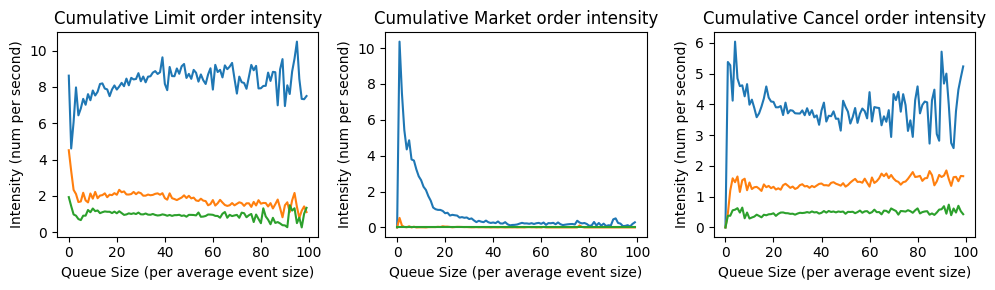

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

for order_type in OrderbookTypes:
    for x in range(0, 2):
        lambdas[0][x][order_type][np.isnan(lambdas[0][x][order_type])] = 0
        lambdas[1][x][order_type][np.isnan(lambdas[1][x][order_type])] = 0
        lambdas[2][x][order_type][np.isnan(lambdas[2][x][order_type])] = 0

    axes[order_type].plot((lambdas[0][OrderbookIndexes.Bid][order_type] + lambdas[0][OrderbookIndexes.Ask][order_type]) / 2, label=f"First Limit")
    axes[order_type].plot((lambdas[1][OrderbookIndexes.Bid][order_type] + lambdas[1][OrderbookIndexes.Ask][order_type]) / 2, label=f"Second Limit")
    axes[order_type].plot((lambdas[2][OrderbookIndexes.Bid][order_type] +  lambdas[2][OrderbookIndexes.Ask][order_type]) / 2, label=f"Third Limit")
    
    if (order_type == OrderbookTypes.Limit):
        order_name = "Limit"
    elif (order_type == OrderbookTypes.Market):
        order_name = "Market"
    elif (order_type == OrderbookTypes.Cancel):
        order_name = "Cancel"

    axes[order_type].set_ylabel("Intensity (num per second)")
    axes[order_type].set_xlabel("Queue Size (per average event size)")
    # axes[0].set_legend(loc='upper right')
    axes[order_type].set_title(f"Cumulative {order_name} order intensity")
fig.tight_layout()
plt.show()

## 2.3.3 Asymptotic behavior under Model I

### Figure 3: Model I, invariant distributions of q±1, q±2, q±3, France Telecom

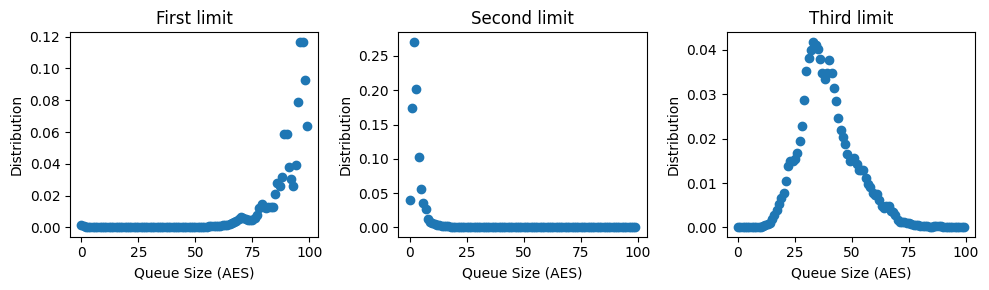

In [61]:
# Invarient Distibutions
def ArrivalDepartureRatio(depth, n):
    limitBid = lambdas[depth][OrderbookIndexes.Bid][0][n]
    cancelBid = lambdas[depth][OrderbookIndexes.Bid][1][n + 1]
    marketBid = lambdas[depth][OrderbookIndexes.Bid][2][n + 1]

    return (limitBid) / (cancelBid + marketBid)

def InvariantDistribution(depth, n):
    product = 1
    
    for j in range(0, n):
        ratio = ArrivalDepartureRatio(depth, j)
        product *= (ratio if ratio != 0 else 1) 

    return product

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

for depth in range(0, DEPTH):
    sum = 0
    for n in range(0, NORMALIZED_QUEUE_MAX):
        sum += InvariantDistribution(depth, n)

    initial_distribution = 1 / (1 + sum)

    x_vals = np.linspace(0, NORMALIZED_QUEUE_MAX - 1, NORMALIZED_QUEUE_MAX)
    y_vals = [initial_distribution * InvariantDistribution(depth, int(x)) for x in x_vals]

    axes[depth].scatter(x_vals, y_vals)
    title = ['First', 'Second', 'Third']
    axes[depth].set_ylabel("Distribution")
    axes[depth].set_xlabel("Queue Size (AES)")
    axes[depth].set_title(f'{title[depth]} limit')
fig.tight_layout()
plt.show()

# 2.4.1 Model IIa: Two sets of dependent queues

In [62]:
empty_top_bid_queue = df['norm_bid1_size'] == 0
top_bid_queue = df['norm_bid1_size'] != 0
empty_top_ask_queue = df['norm_ask1_size'] == 0
top_ask_queue = df['norm_ask1_size'] != 0

# it looks like I am missing  142,184 rows of data.... oops!
display(df[empty_top_bid_queue])

,time,type,orderId,size,price,direction,event_lapse,midprice,reference_price,norm_bid1_price,norm_bid1_size,norm_ask1_price,norm_ask1_size,norm_bid2_price,norm_bid2_size,norm_ask2_price,norm_ask2_size,norm_bid3_price,norm_bid3_size,norm_ask3_price,norm_ask3_size
11,34200.211338,5.0,0.0,125.0,275200.0,-1.0,0.000000,275200.0,275250.0,275200.0,0,275300.0,1000,275100.0,300,275400.0,373,275000.0,300,275500.0,100
12,34200.211455,1.0,16168655.0,200.0,275100.0,1.0,0.000117,275200.0,275250.0,275200.0,0,275300.0,1000,275100.0,300,275400.0,373,275000.0,300,275500.0,100
13,34200.211462,1.0,16168657.0,100.0,275100.0,1.0,0.000007,275200.0,275250.0,275200.0,0,275300.0,1000,275100.0,500,275400.0,373,275000.0,300,275500.0,100
14,34200.211464,1.0,16168658.0,200.0,275100.0,1.0,0.000002,275200.0,275250.0,275200.0,0,275300.0,1000,275100.0,600,275400.0,373,275000.0,300,275500.0,100
15,34200.211558,3.0,16168655.0,200.0,275100.0,1.0,0.000094,275200.0,275250.0,275200.0,0,275300.0,1000,275100.0,800,275400.0,373,275000.0,300,275500.0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580563,57597.884458,2.0,287049614.0,2100.0,267000.0,1.0,0.000006,267200.0,267250.0,267200.0,0,267300.0,155383,267100.0,52208,267400.0,60874,267000.0,32083,267500.0,68078
580564,57597.884490,1.0,287059304.0,100.0,267400.0,-1.0,0.000032,267200.0,267250.0,267200.0,0,267300.0,155383,267100.0,52208,267400.0,60874,267000.0,29983,267500.0,68078
580565,57597.884520,3.0,287059303.0,800.0,267300.0,-1.0,0.000031,267200.0,267250.0,267200.0,0,267300.0,155383,267100.0,52208,267400.0,60974,267000.0,29983,267500.0,68078
580566,57597.884646,3.0,287059267.0,2600.0,267300.0,-1.0,0.000126,267200.0,267250.0,267200.0,0,267300.0,154583,267100.0,52208,267400.0,60974,267000.0,29983,267500.0,68078


### 2.4.2: Model IIa: Empiracal Study

Figure 4: Intensities at Q2 as functions of 1q1>0 and q2,

Price Level 1 | AES 619.7531620521039
Price Level 2 | AES 421.5098594406375
Price Level 3 | AES 401.44114688128775
Price Level 1 | AES 462.34945234977545
Price Level 2 | AES 456.7537670377436
Price Level 3 | AES 453.994560786102


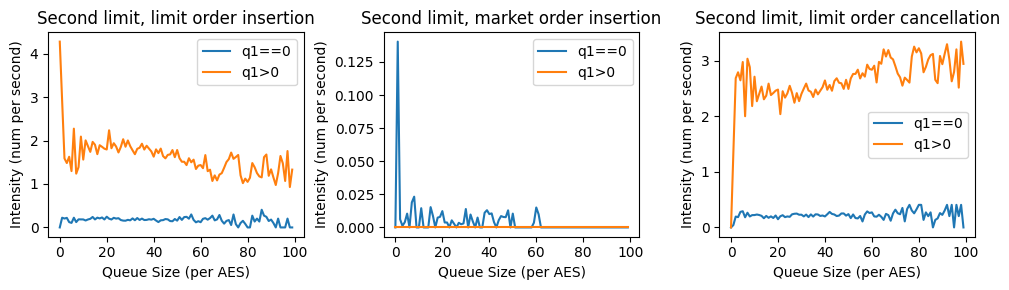

In [63]:
order_type_titles = ["limit order insertion", "market order insertion", "limit order cancellation"]

queue_empty_bid_lambdas = generateIntensityValues(df[empty_top_bid_queue])
queue_non_empty_bid_lambdas = generateIntensityValues(df[top_bid_queue])
# queue_empty_ask_lambdas = generateIntensityValues(df[empty_top_ask_queue])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

for order_type in OrderbookTypes:
    axes[order_type].plot(queue_empty_bid_lambdas[1][OrderbookIndexes.Bid][order_type], label=f"q1==0")
    axes[order_type].plot(queue_non_empty_bid_lambdas[1][OrderbookIndexes.Bid][order_type], label=f"q1>0")
    
    axes[order_type].set_ylabel("Intensity (num per second)")
    axes[order_type].set_xlabel("Queue Size (per AES)")
    axes[order_type].legend()
    axes[order_type].set_title(f'Second limit, {order_type_titles[order_type]}')
fig.tight_layout()
plt.show()

### 2.4.3 Model IIa: Asympotic behavior

In [66]:
# # Joint distribution of queue sizes
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

# for order_type in OrderbookTypes:
#     axes[order_type].scatter(queue_empty_bid_lambdas[1][OrderbookIndexes.Bid][order_type], queue_non_empty_bid_lambdas[1][OrderbookIndexes.Bid][order_type])
#     axes[order_type].set_ylabel("Intensity (num per second) q1>0")
#     axes[order_type].set_xlabel("Intensity (num per second) q1==0")
#     axes[order_type].set_title(f'Second limit, {order_type_titles[order_type]}')
# fig.tight_layout()
# plt.show()

### 2.4.4 Model IIb: Modeling bid-ask dependences

In this model, market participants at Q±1 adjust their behavior not only according to the target queue size, but also to the size of the opposite queue.

In [72]:
class QueueTypes(IntEnum):
    Q_empty = 0
    Q_small = 1
    Q_medium = 2
    Q_large = 3

bid_queue_size_33_percentile = df['norm_bid1_size'].quantile(0.33)
ask_queue_size_33_percentile = df['norm_ask1_size'].quantile(0.33)
bid_queue_size_66_percentile = df['norm_bid1_size'].quantile(0.66)
ask_queue_size_66_percentile = df['norm_ask1_size'].quantile(0.66)

def categorize_queue(queue_size, percentile_33, percentile_66):
    if(queue_size == 0):
        return QueueTypes.Q_empty
    elif(queue_size < percentile_33):
        return QueueTypes.Q_small
    elif(queue_size < percentile_66):
        return QueueTypes.Q_medium
    else:
        return QueueTypes.Q_large
    
df['bid_queue_type'] = df['norm_bid1_size'].apply(categorize_queue, args=(bid_queue_size_33_percentile, bid_queue_size_66_percentile))
df['ask_queue_type'] = df['norm_ask1_size'].apply(categorize_queue, args=(ask_queue_size_33_percentile, ask_queue_size_66_percentile))
print(df['bid_queue_type'].mean())
print(df['ask_queue_type'].mean())

1.9188508663078778
1.8557128818010804


Price Level 1 | AES 619.7531620521039
Price Level 2 | AES 421.5098594406375
Price Level 3 | AES 401.44114688128775
Price Level 1 | AES 381.1629269161952
Price Level 2 | AES 376.5579312856562
Price Level 3 | AES 445.51745698437946
Price Level 1 | AES 419.6054204356376
Price Level 2 | AES 462.9771357549416
Price Level 3 | AES 448.584607150979
Price Level 1 | AES 549.3839012281875
Price Level 2 | AES 503.11565135815385
Price Level 3 | AES 466.10942790503304


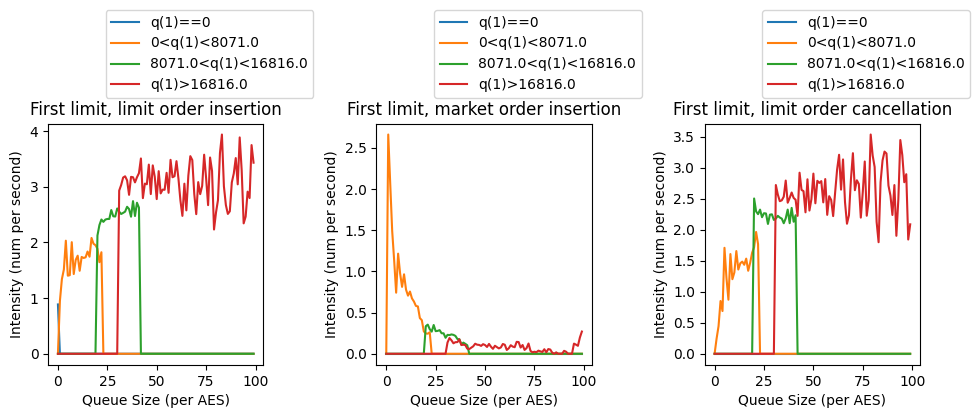

In [80]:
# The rates λL±1 and λC±1 are therefore modeled as functions of q±1 and Sm,l(q∓1).
order_type_titles = ["limit order insertion", "market order insertion", "limit order cancellation"]

bid_empty_queue = df['bid_queue_type'] == 0
bid_small_queue = df['bid_queue_type'] == 1
bid_medium_queue = df['bid_queue_type'] == 2
bid_large_queue = df['bid_queue_type'] == 3

ask_empty_queue = df['ask_queue_type'] == 0
ask_small_queue = df['ask_queue_type'] == 1
ask_medium_queue = df['ask_queue_type'] == 2
ask_large_queue = df['ask_queue_type'] == 3

bid_empty_queue_lambdas = generateIntensityValues(df[bid_empty_queue])
bid_small_queue_lambdas = generateIntensityValues(df[bid_small_queue])
bid_medium_queue_lambdas = generateIntensityValues(df[bid_medium_queue])
bid_large_queue_lambdas = generateIntensityValues(df[bid_large_queue])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

for order_type in OrderbookTypes:
    axes[order_type].plot(bid_empty_queue_lambdas[0][OrderbookIndexes.Bid][order_type], label=f"q(1)==0")
    axes[order_type].plot(bid_small_queue_lambdas[0][OrderbookIndexes.Bid][order_type], label=f"0<q(1)<{bid_queue_size_33_percentile}")
    axes[order_type].plot(bid_medium_queue_lambdas[0][OrderbookIndexes.Bid][order_type], label=f"{bid_queue_size_33_percentile}<q(1)<{bid_queue_size_66_percentile}")
    axes[order_type].plot(bid_large_queue_lambdas[0][OrderbookIndexes.Bid][order_type], label=f"q(1)>{bid_queue_size_66_percentile}")
    
    axes[order_type].set_ylabel("Intensity (num per second)")
    axes[order_type].set_xlabel("Queue Size (per AES)")
    axes[order_type].legend(loc='upper center', bbox_to_anchor=(0.5, 1, 0.5, 0.5))
    axes[order_type].set_title(f'First limit, {order_type_titles[order_type]}')
fig.tight_layout()
plt.show()
